# When the Model Is Wrong

- In the maze example presented in the Dyna Maze, the changes in the model were relatively modest. The model started out empty, and was then filled only with exactly correct information.
- In general, we cannot expect to be so fortunate. Models may be incorrect because:
  - the environment is stochastic and only a limited number of samples have been observed,
  - the model was learned using function approximation that has generalized imperfectly,
  - the environment has changed and its new behavior has not yet been observed.
- When the model is incorrect, the planning process is likely to compute a suboptimal policy.
  - In some cases, the suboptimal policy computed by planning quickly leads to the discovery and correction of the modeling error. 
  - This tends to happen when the model is optimistic in the sense of predicting greater reward or better state transitions than are actually possible.
  - The planned policy attempts to exploit these opportunities and in doing so discovers that they do not exist.

In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [2]:
from src.maze import Maze
from src.dyna import DynaParams
from src.functions import changing_maze

## Blocking Maze

A maze example illustrating this relatively minor kind of modeling error and recovery from it is shown in Figure 8.4.
- Initially, there is a short path from start to goal, to the right of the barrier, as shown in the upper left of the figure.
- After 1000 time steps, the short path is “blocked,” and a longer path is opened up along the left-hand side of the barrier, as shown in upper right of the figure.

In [3]:
from IPython.display import Image

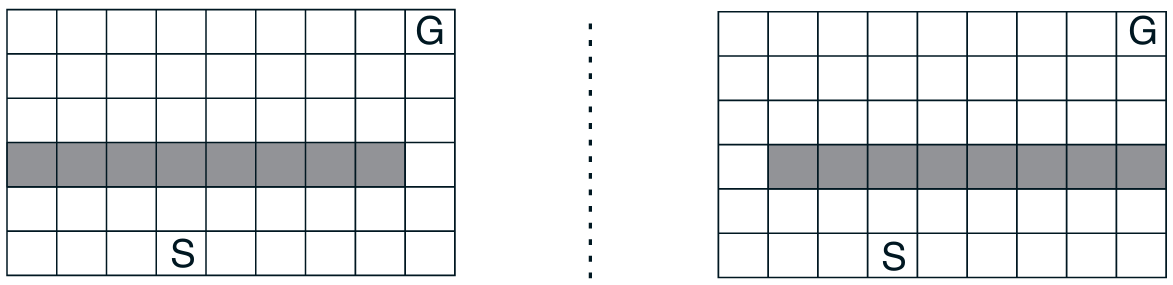

In [4]:
Image(filename="../book_images/Figure_8_4_inset.PNG")

The graph shows average cumulative reward for a Dyna-Q agent and an enhanced Dyna-Q+ agent to be described shortly.
- The 1st part of the graph shows that both Dyna agents found the short path within 1000 steps.
- When the environment changed, the graphs become flat, indicating a period during which the agents obtained no reward because they were wandering around behind the barrier.
- After a while, however, they were able to find the new opening and the new optimal behavior.

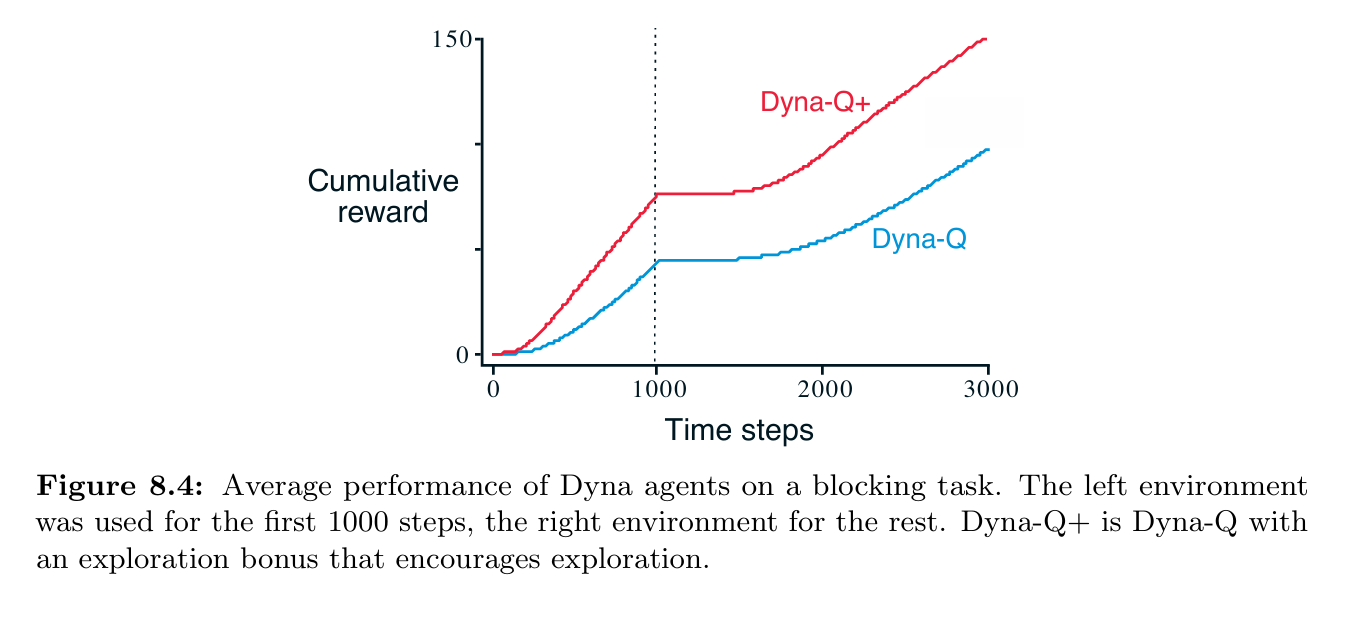

In [5]:
Image(filename="../book_images/Figure_8_4_graph.PNG")

- Greater difficulties arise when the environment changes to become better than it was before, and yet the formerly correct policy does not reveal the improvement.
- In these cases the modeling error may not be detected for a long time, if ever.

In [6]:
# Set up a blocking maze instance
blocking_maze = Maze()
blocking_maze.start = [5, 3]
blocking_maze.goals = [[0, 8]]
blocking_maze.old_obstacles = [[3, i] for i in range(0, 8)]

In [7]:
# New obstacles will block the optimal path
blocking_maze.new_obstacles = [[3, i] for i in range(1, 9)]

# Step limit
blocking_maze.max_steps = 3000

# Obstacles will change after 1000 steps. The exact step for changing will be different.
# However, given that 1000 steps is long enough for both algorithms to converge, the difference is guaranteed to be very small
blocking_maze.obstacle_switch_time = 1000

In [9]:
# Set up Dyna parameters
dyna_params = DynaParams()
dyna_params.step_size = 1.0
dyna_params.planning_steps = 10
dyna_params.runs = 20

# Time weight must be small, as the reward for getting the goal is only 1
dyna_params.time_weight = 1e-4

In [10]:
# Get the rewards
rewards = changing_maze(blocking_maze, dyna_params)

100%|██████████| 20/20 [02:12<00:00,  6.62s/it]


In [11]:
# Plotting
for i in range(len(dyna_params.methods)):
    plt.plot(rewards[i, :], label=dyna_params.methods[i])

plt.xlabel("Time steps")
plt.ylabel("Cumulative reward")
plt.legend()

plt.savefig("../generated_images/figure_8_4.png")
plt.close()

## Shortcut Maze

The problem caused by this kind of environmental change is illustrated by the maze example shown in Figure 8.5.
- Initially, the optimal path is to go around the left side of the barrier (upper left).
- After 3000 steps, however, a shorter path is opened up along the right side, without disturbing the longer path (upper right).

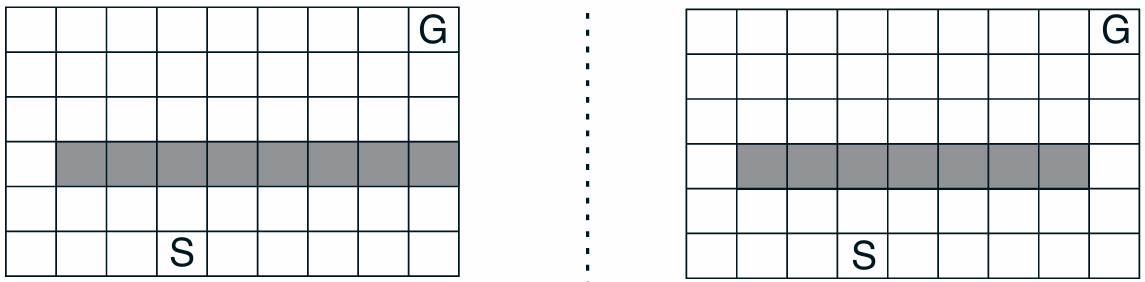

In [12]:
Image(filename="../book_images/Figure_8_5_inset.PNG")

The graph shows that the regular Dyna-Q agent never switched to the shortcut. In fact, it never realized that it existed.
- Its model said that there was no shortcut, so the more it planned, the less likely it was to step to the right and discover it.
- Even with an $\varepsilon$-greedy policy, it is very unlikely that an agent will take so many exploratory actions as to discover the shortcut.

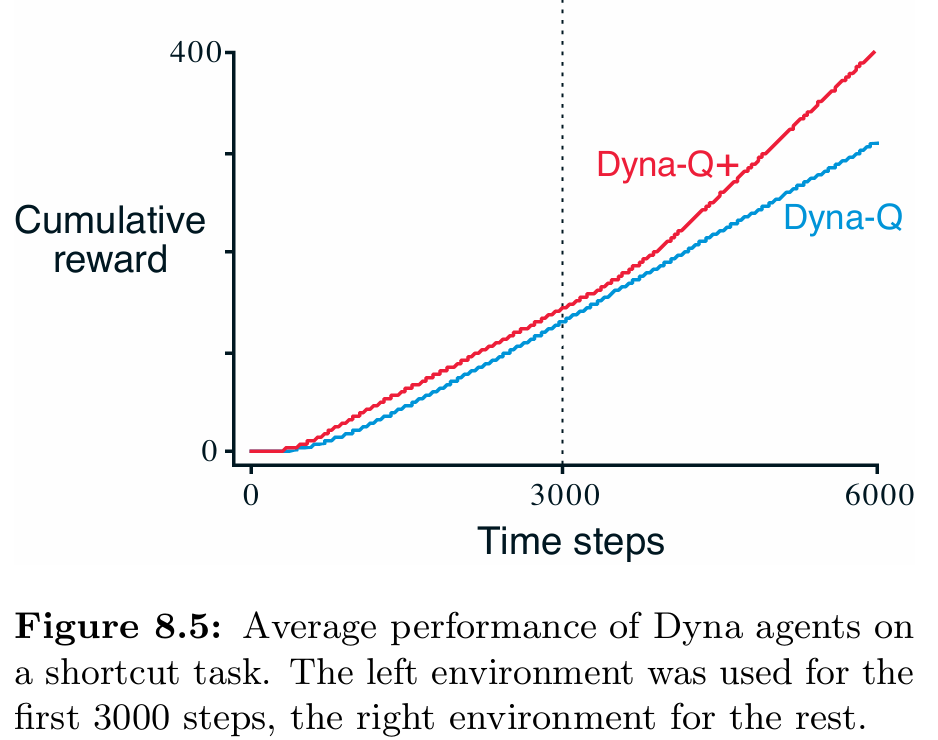

In [13]:
Image(filename="../book_images/Figure_8_5_graph.PNG")

In [14]:
# Set up a shortcut maze instance
shortcut_maze = Maze()
shortcut_maze.start = [5, 3]
shortcut_maze.goals = [[0, 8]]
shortcut_maze.old_obstacles = [[3, i] for i in range(1, 9)]

In [15]:
# New obstacles will have a shorter path
shortcut_maze.new_obstacles = [[3, i] for i in range(1, 8)]

# Step limit
shortcut_maze.max_steps = 6000

# Obstacles will change after 3000 steps. The exact step for changing will be different.
# However, given that 3000 steps is long enough for both algorithms to converge, the difference is guaranteed to be very small.
shortcut_maze.obstacle_switch_time = 3000

In [16]:
# Set up Dyna parameters
dyna_params = DynaParams()

# 50-step planning
dyna_params.planning_steps = 50

dyna_params.runs = 5
dyna_params.time_weight = 1e-3
dyna_params.step_size = 1.0

In [17]:
# Get the rewards
rewards = changing_maze(shortcut_maze, dyna_params)

100%|██████████| 5/5 [04:14<00:00, 50.97s/it]


In [18]:
# Plotting
for i in range(len(dyna_params.methods)):
    plt.plot( rewards[i, :], label=dyna_params.methods[i])

plt.xlabel("Time steps")
plt.ylabel("Cumulative reward")
plt.legend()

plt.savefig("../generated_images/figure_8_5.png")
plt.close()

The general problem here is another version of the conflict between exploration and exploitation.
- In a planning context, exploration means trying actions that improve the model, whereas exploitation means behaving in the optimal way given the current model.
- We want the agent to explore to find changes in the environment, but not so much that performance is greatly degraded.
- As in the earlier exploration/exploitation conflict, there probably is no solution that is both perfect and practical, but simple heuristics are often effective.

The Dyna-Q+ agent that did solve the shortcut maze uses one such heuristic.
- This agent keeps track for each state–action pair of how many time steps have elapsed since the pair was last tried in a real interaction with the environment.
  - The more time that has elapsed, the greater (we might presume) the chance that the dynamics of this pair has changed and that the model of it is incorrect.
- To encourage behavior that tests long-untried actions, a special “bonus reward” is given on simulated experiences involving these actions.
  - In particular, if the modeled reward for a transition is $r$, and the transition has not been tried in $\tau$ time steps, then planning updates are done as if that transition produced a reward of $r+\kappa \sqrt\tau$, for some small $\kappa$.
  - This encourages the agent to keep testing all accessible state transitions and even to find long sequences of actions in order to carry out such tests.
  - The Dyna-Q+ agent was changed in 2 other ways as well:
    1. actions that had never been tried before from a state were allowed to be considered in the planning step (f) of the Tabular Dyna-Q algorithm pseudocode,
    2. the initial model for such actions was that they would lead back to the same state with a reward of 0.
- Of course all this testing has its cost, but in many cases, as in the shortcut maze, this kind of computational curiosity is well worth the extra exploration.
